<a href="https://colab.research.google.com/github/MaximilianLae/DL_Skin_Disease_Classification/blob/main/Individual%20Notebooks/Solution5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gymnasium as gym

import time
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
import itertools
import pickle
from stable_baselines3 import DQN
#from stable_baselines3.common.envs import DummyVecEnv
from gymnasium.spaces import Discrete, Box
from stable_baselines3 import A2C
import torch
from stable_baselines3.common.env_util import make_vec_env

## Let's create 5th solution for try

In [ ]:
custom_config = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,  # [s]
    "collision_reward": -50,  # Custom collision reward
    "right_lane_reward": 0,  # Custom right lane reward
    "high_speed_reward": 10,  # Custom high speed reward
    "lane_change_reward": 0.1,   # Custom lane change reward
    "reward_speed_range": [20, 30],
    "normalize_reward": False,  # Disable normalization
    "offroad_terminal": False,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"]
    },
    "action": {
        "type": "DiscreteAction",
        "actions_per_axis": 3,
        "steering_range": [-np.pi / 4, np.pi / 4],
        "speed_range": [20, 30],
        "acceleration_range": [-5, 5]
    },
}

# Define the default configuration
default_config = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,  # [s]
    "collision_reward": -1,  # Default collision reward
    "right_lane_reward": 0.1,  # Default right lane reward
    "high_speed_reward": 0.4,  # Default high speed reward
    "lane_change_reward": 0,   # Default lane change reward
    "reward_speed_range": [20, 30],
    "normalize_reward": True,  # Enable normalization
    "offroad_terminal": False,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"]
    },
    "action": {
        "type": "DiscreteAction",
        "actions_per_axis": 3,
        "steering_range": [-np.pi / 4, np.pi / 4],
        "speed_range": [20, 30],
        "acceleration_range": [-5, 5]
    },
}

# Create the environment with custom configuration for training
env = gym.make('highway-v0')
env.configure(custom_config)

c:\Anaconda\envs\NEL\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


In [ ]:
# Wrapper to limit the number of steps per episode and handle rewards
class LimitStepsWrapper(gym.Wrapper):
    def __init__(self, env, max_steps=100, training=True):
        super(LimitStepsWrapper, self).__init__(env)
        self.max_steps = max_steps
        self.current_step = 0
        self.training = training

    def reset(self, **kwargs):
        self.current_step = 0
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple) and len(result) == 2:
            obs, info = result
            return obs
        return result

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.current_step += 1

        # Penalize for backward movement and reward for forward movement only during training
        if self.training:
            speeds = obs[:, 2]  # Assuming vx is the speed in the third column of each row
            if (speeds < 0).any():
                reward -= 0.1  # Arbitrary penalty value for moving backwards

        if self.current_step >= self.max_steps:
            done = True
        return obs, reward, done, truncated, info

# Wrap the environment to limit steps per episode during training
env = LimitStepsWrapper(env, training=True)

In [ ]:
obs = env.reset()
print("Observation shape:", obs.shape) # verify the observation shape

Observation shape: (5, 4)


In [ ]:
# Define the bins for throttle and steering
acceleration_range = custom_config["action"]["acceleration_range"]
steering_range = custom_config["action"]["steering_range"]
actions_per_axis = custom_config["action"]["actions_per_axis"]

throttle_bins = np.linspace(acceleration_range[0], acceleration_range[1], actions_per_axis)
steering_bins = np.linspace(steering_range[0], steering_range[1], actions_per_axis)

# Create the Cartesian product of throttle and steering bins
all_actions = list(itertools.product(throttle_bins, steering_bins))

# Print the mapping of action indices to actions
for idx, action in enumerate(all_actions):
    print(f"Action {idx}: Throttle = {action[0]}, Steering = {action[1]}")

Action 0: Throttle = -5.0, Steering = -0.7853981633974483
Action 1: Throttle = -5.0, Steering = 0.0
Action 2: Throttle = -5.0, Steering = 0.7853981633974483
Action 3: Throttle = 0.0, Steering = -0.7853981633974483
Action 4: Throttle = 0.0, Steering = 0.0
Action 5: Throttle = 0.0, Steering = 0.7853981633974483
Action 6: Throttle = 5.0, Steering = -0.7853981633974483
Action 7: Throttle = 5.0, Steering = 0.0
Action 8: Throttle = 5.0, Steering = 0.7853981633974483


In [ ]:
model = DQN('MlpPolicy', env, verbose=1)

# Train for a specified number of episodes
cumulative_rewards = []
episode_lengths = []
collisions = []
action_counts = np.zeros(env.action_space.n)
all_observations = []  # List to store observations for each episode

num_episodes = 200

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0
    steps = 0
    collision_count = 0
    episode_observations = []

    while not done and steps < 100:
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_observations.append(obs)
        total_reward += reward
        steps += 1
        if info.get("crashed", False):
            collision_count += 1
        action_counts[action] += 1

    cumulative_rewards.append(total_reward)
    episode_lengths.append(steps)
    collisions.append(collision_count)
    all_observations.append(episode_observations)
    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1: Total Reward: 4.732968006418922
Episode 2: Total Reward: -0.25378479492655265
Episode 3: Total Reward: -0.25378479492655265
Episode 4: Total Reward: -0.25378479492655265
Episode 5: Total Reward: -0.25378479492655265
Episode 6: Total Reward: -0.25378479492655265
Episode 7: Total Reward: -0.25378479492655265
Episode 8: Total Reward: 60.55466371011753
Episode 9: Total Reward: 4.732968006418922
Episode 10: Total Reward: -4.199999999999984
Episode 11: Total Reward: -5.099999999999981
Episode 12: Total Reward: -0.25378479492655265
Episode 13: Total Reward: 60.325845196748226
Episode 14: Total Reward: -0.25378479492655265
Episode 15: Total Reward: -0.25378479492655265
Episode 16: Total Reward: -0.25378479492655265
Episode 17: Total Reward: -4.699999999999982
Episode 18: Total Reward: 60.325845196748226
Episode 19: Total Reward: -0.25378479492655265
Episode 20: Total Reward: -0.353784794926

In [ ]:
save_path = "C:/Users/laech/Documents/NOVA IMS/RL/Project Handout-20240526"
os.makedirs(save_path, exist_ok=True)
model_file = os.path.join(save_path, "dqn_highway_custom")

# Save the trained model
model.save(model_file)

In [ ]:
model = DQN.load(model_file)

In [ ]:
# env for evaluation
env.configure(default_config)
env = LimitStepsWrapper(env, training=False)

c:\Anaconda\envs\NEL\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


In [ ]:
obs = env.reset()
print("Observation shape (evaluation):", obs.shape) # verify the observation shape

Observation shape (evaluation): (5, 4)


In [ ]:
# Evaluate the agent on the default configuration
evaluation_rewards = []
evaluation_observations = []  # List to store observations for each evaluation episode

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0
    steps = 0
    episode_observations = []

    while not done and steps < 100:
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_observations.append(obs)
        total_reward += reward
        steps += 1

    evaluation_rewards.append(total_reward)
    evaluation_observations.append(episode_observations)
    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

average_reward = sum(evaluation_rewards) / len(evaluation_rewards)
print(f"Average Reward over {num_episodes} episodes: {average_reward}")

env.close()

Episode 1: Total Reward: 16.0753558719133
Episode 2: Total Reward: 1.9514546276908544
Episode 3: Total Reward: 16.0753558719133
Episode 4: Total Reward: 0.5403435165797373
Episode 5: Total Reward: 0.5403435165797373
Episode 6: Total Reward: 37.95555555555557
Episode 7: Total Reward: 5.490656924615628
Episode 8: Total Reward: 1.844444444444453
Episode 9: Total Reward: 29.090007177798007
Episode 10: Total Reward: 16.0753558719133
Episode 11: Total Reward: 0.5403435165797373
Episode 12: Total Reward: 16.0753558719133
Episode 13: Total Reward: 0.5403435165797373
Episode 14: Total Reward: 16.0753558719133
Episode 15: Total Reward: 64.01111111111109
Episode 16: Total Reward: -4.48888888888889
Episode 17: Total Reward: 29.090007177798007
Episode 18: Total Reward: 35.09999999999999
Episode 19: Total Reward: 2.0514546276908545
Episode 20: Total Reward: 2.0514546276908545
Episode 21: Total Reward: 0.47367684991307146
Episode 22: Total Reward: 1.8514546276908543
Episode 23: Total Reward: 37.23510

In [ ]:
# adding plots for performance and decision making

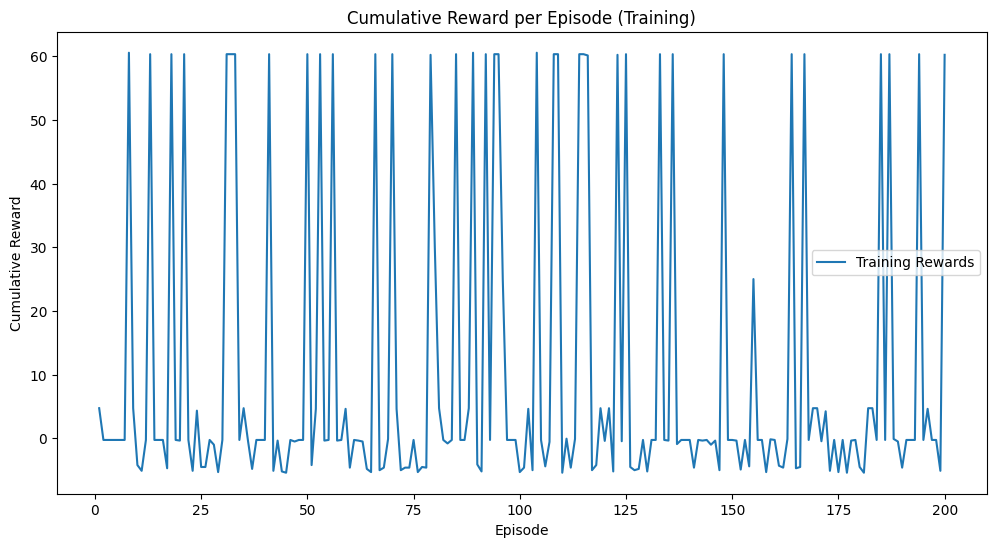

In [ ]:
# Plot the cumulative reward per episode for training
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_episodes + 1), cumulative_rewards, label='Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward per Episode (Training)')
plt.legend()
plt.show()

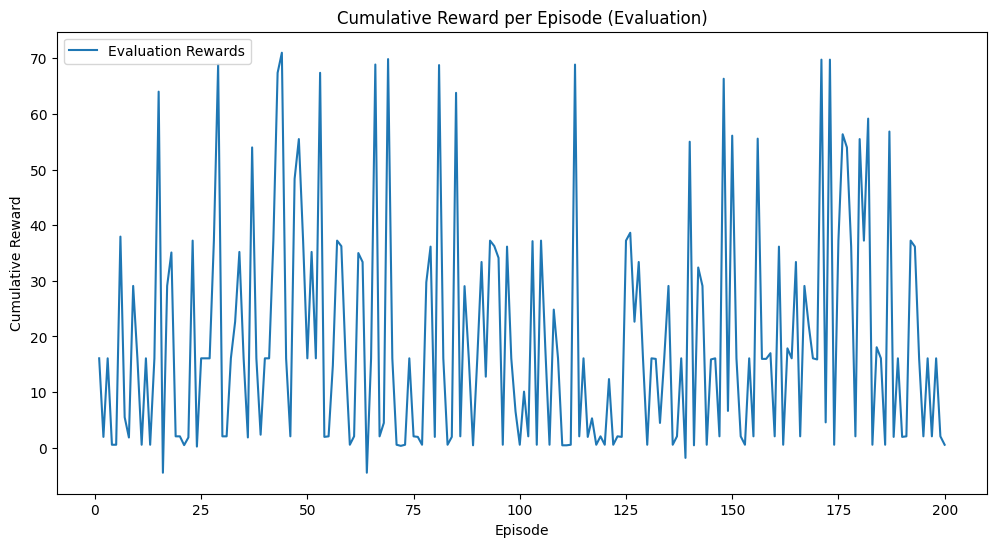

In [ ]:
# Plot the cumulative reward per episode for evaluation
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_episodes + 1), evaluation_rewards, label='Evaluation Rewards')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward per Episode (Evaluation)')
plt.legend()
plt.show()

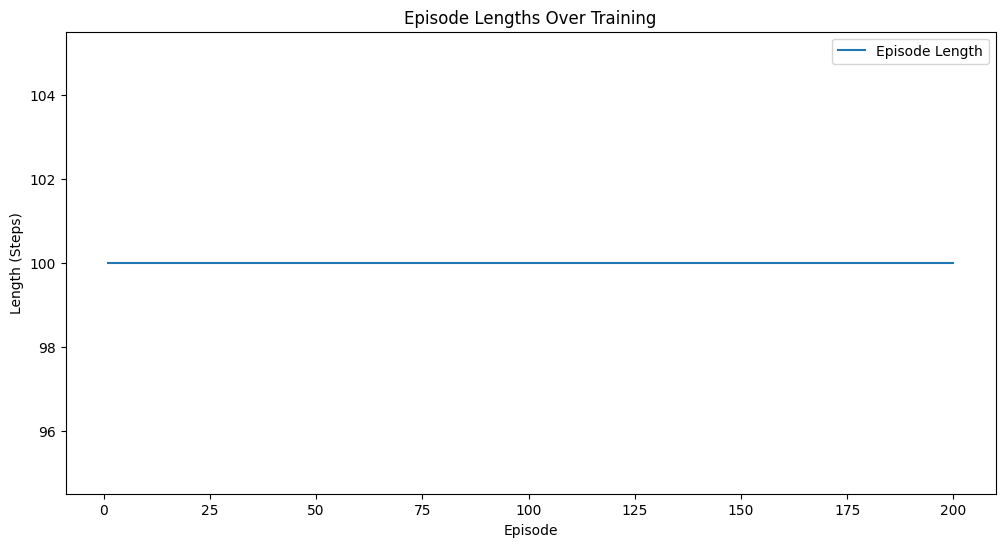

In [ ]:
# Plot episode lengths
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_episodes + 1), episode_lengths, label='Episode Length')
plt.xlabel('Episode')
plt.ylabel('Length (Steps)')
plt.title('Episode Lengths Over Training')
plt.legend()
plt.show()

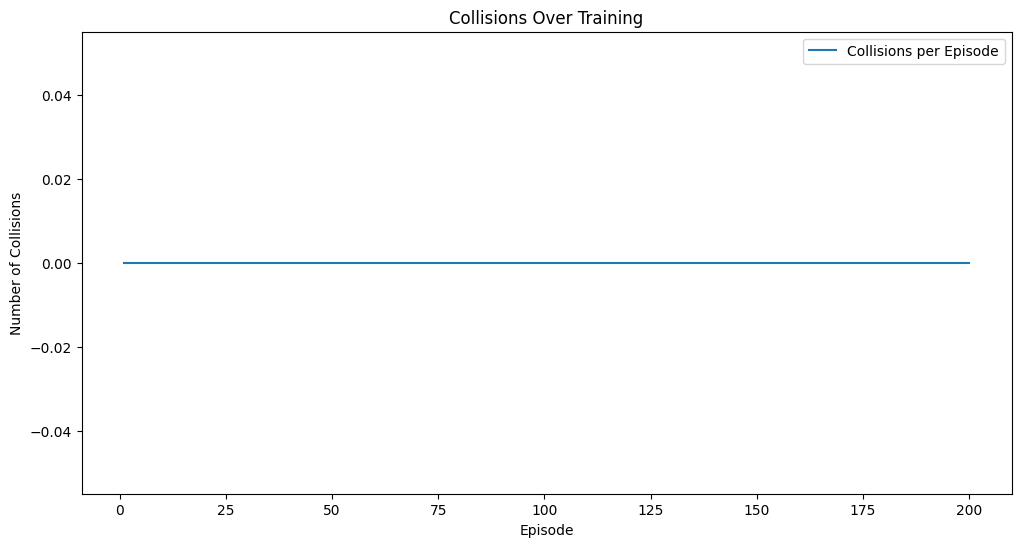

In [ ]:
# Plot collision counts
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_episodes + 1), collisions, label='Collisions per Episode')
plt.xlabel('Episode')
plt.ylabel('Number of Collisions')
plt.title('Collisions Over Training')
plt.legend()
plt.show()

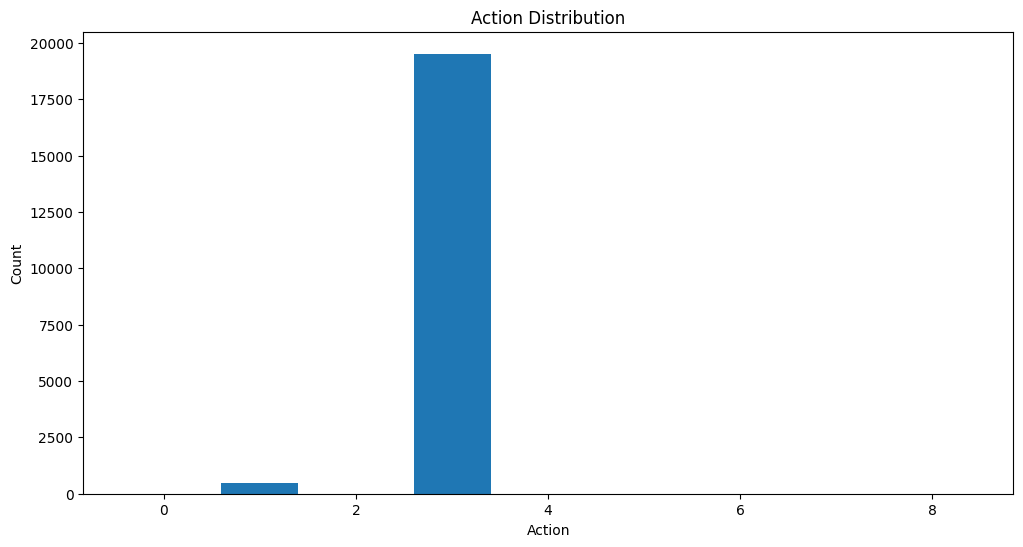

In [ ]:
# Plot action distribution
plt.figure(figsize=(12, 6))
plt.bar(range(env.action_space.n), action_counts)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Action Distribution')
plt.show()

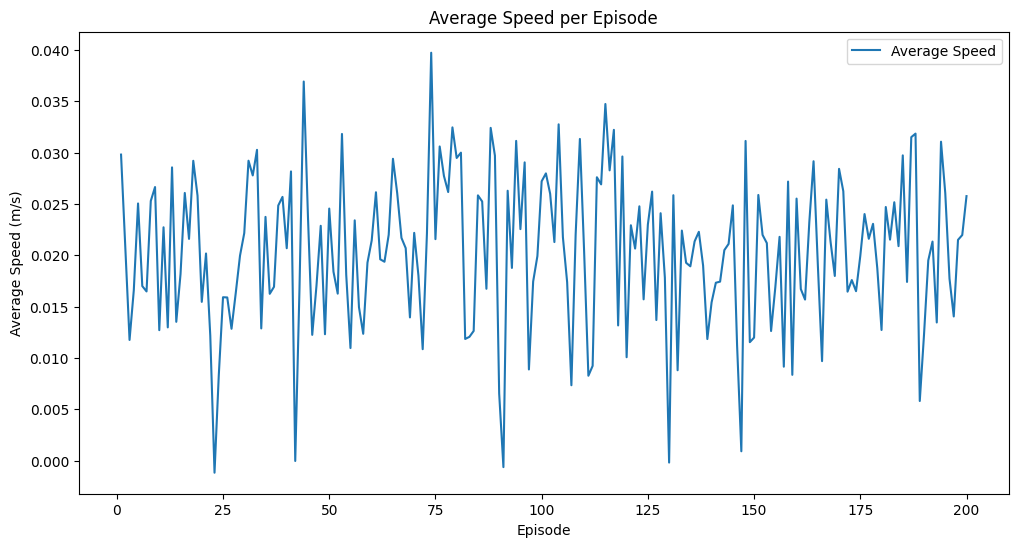

In [ ]:
# Average speed per episode
average_speeds = [np.mean([obs[2] for obs in episode_observations]) for episode_observations in all_observations]
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_episodes + 1), average_speeds, label='Average Speed')
plt.xlabel('Episode')
plt.ylabel('Average Speed (m/s)')
plt.title('Average Speed per Episode')
plt.legend()
plt.show()